Step1: define the problem
1. the business objective: identify factors and 2. build a model to predict if order will be fulfilled on time or delay.
2. the kind of problem: The problem is supurvised learning, and a classfication problem
3. performance evaluation: accuracy, and recall

In [2]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [350]:
#import data
df=pd.read_csv('Consolidated data.csv')
print('Dataframe dimensions:', df.shape)


Dataframe dimensions: (12065, 58)


Step2: Data Cleaning and manipulation before data exploration

In [351]:
#subset only delivered and know labels' data
df_d=df[(df['SHP_PACK_DLVRY_STS_KEY']==6)&(df['SPDPD_KEY']!=1)&(df['SPDPD_KEY']!=10)]
df_d=df_d.dropna(subset=['SPDPD_KEY'])


In [352]:
df_d['ontime_ornot']=df_d['SPDPD_KEY']
df_d['ontime_ornot']=df_d['ontime_ornot'].replace([2,4],1).replace([3,5,6,7,8,9],0)
df_d.head()



,ORDER_NUM,ITEM_KEY,DSTRBTR_KEY,CITY_STATE_INFO_KEY,ORDER_DT,ORDER_TS,EXPECTED_DELIVERY_TS,LEAST_DELIVERY_TS,ITM_OFFR_ID,DETERMINED_DELIVERY_TS,...,ORDER_PLACED_DT,TOT_AMT,TAX_AMT,CURR_STS_ID,CONSUMER_CNTCT_ID,GUEST_ORDER_IND,CORP_ORDER_IND,DEVICE_TYPE,FRAUD_CHECK_REQD_IND,ontime_ornot
22,TSO-1676031538,6214.0,4,5.0,4/6/18,4/6/2018 16:02:58.000000-07:00,4/11/2018 12:00:00.000000-07:00,4/11/2018 00:00:00.000000-07:00,C08EF0DFB86F43879C505882F6039F46,4/11/2018 00:00:00.000000-07:00,...,1/7/17,73.50,3.50,897,NaN,0,NaN,Browser,NaN,1
23,TSO-1676420038,6401.0,1,5.0,6/8/18,6/8/2018 07:34:34.000000-07:00,6/13/2018 12:00:00.000000-07:00,6/13/2018 00:00:00.000000-07:00,1A76CA58381F471592B14D0BFF53079A,6/13/2018 00:00:00.000000-07:00,...,11/11/16,89.05,6.56,897,NaN,0,NaN,Browser,NaN,1
24,TSO-1773690007,6233.0,2,5.0,2/7/18,2/7/2018 09:22:38.000000-08:00,2/19/2018 20:00:00.000000-08:00,2/13/2018 00:00:00.000000-08:00,B7A1827D8D8846858DD5DD0BD630D9D2,2/19/2018 00:00:00.000000-08:00,...,11/11/16,54.26,3.31,897,NaN,0,NaN,Browser,NaN,1
25,TSO-1676420038,6399.0,1,5.0,6/8/18,6/8/2018 07:34:34.000000-07:00,6/12/2018 12:00:00.000000-07:00,6/12/2018 00:00:00.000000-07:00,B8138A95ACF8467E9E9354D7F0DA84E9,6/12/2018 00:00:00.000000-07:00,...,11/11/16,89.05,6.56,897,NaN,0,NaN,Browser,NaN,1
26,TSO-1676420038,6713.0,1,5.0,6/8/18,6/8/2018 07:34:34.000000-07:00,6/12/2018 12:00:00.000000-07:00,6/12/2018 00:00:00.000000-07:00,24403375D24B45BF8D9DC4C362E0AE69,6/12/2018 00:00:00.000000-07:00,...,11/11/16,89.05,6.56,897,NaN,0,NaN,Browser,NaN,1


In [353]:
#ratio of delay:
1-sum(df_d['ontime_ornot'])/len(df_d)

0.07815777473780205

In [354]:
#drop clearly not relevant columns
df_d=df_d.drop(['CREATED_TS','CREATED_USER','UPDATED_TS','UPDATED_USER','FRAUD_CHECK_REQD_IND','CORP_ORDER_IND','CONSUMER_CNTCT_ID','TENANT_ASSOC_ID'],axis=1)


In [355]:
#unify null
df_d=df_d.replace('?',np.nan)
df_d=df_d.replace('NULL',np.nan)


In [356]:
#clean time stamp
for i in (5,6,7,9,10,12,15,16,17):
    for j in range(len(df_d)):
        if type(df_d.iloc[j,i]) is str:
            df_d.iloc[j,i]=df_d.iloc[j,i][:-13]


In [357]:
#clean SHIPPED_PACKAGE_PRICE_AMT
df_d['SHIPPED_PACKAGE_PRICE_AMT']=df_d['SHIPPED_PACKAGE_PRICE_AMT'].str.replace(",","").astype(float)
df_d['SHIPPED_PACKAGE_PRICE_AMT']=df_d['SHIPPED_PACKAGE_PRICE_AMT'].astype(float)

In [358]:
#change time stamp date type

for i in ('ORDER_TS','EXPECTED_DELIVERY_TS','LEAST_DELIVERY_TS','DETERMINED_DELIVERY_TS','EXPECTED_SHIPMENT_TS','CARRIER_EXPECTED_DELIVERY_TS','CARGO_DEPARTED_TS','INITIAL_DLVR_ATMPT_TS','FINAL_DELIVERY_ATMPT_TS','ACTUAL_DELIVERY_TS','ORDER_REL_TS','ORDER_PLACED_TS'):
    df_d[i]=pd.to_datetime(df_d[i])
    


In [359]:
#change index
df_d.index=range(len(df_d))


In [360]:
#create test data: stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
sp = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in sp.split(df_d, df_d['ontime_ornot']):
        df_train = df_d.loc[train_index]
        df_test = df_d.loc[test_index]
print(df_train.shape)
print(df_test.shape)
combine=[df_train,df_test]


(8772, 51)
(2193, 51)


Step3: Data exploration
(more on the report)

DSTRBTR_KEY
1    0.094772
2    0.034188
3    0.071545
4    0.069767
Name: ontime_ornot, dtype: float64


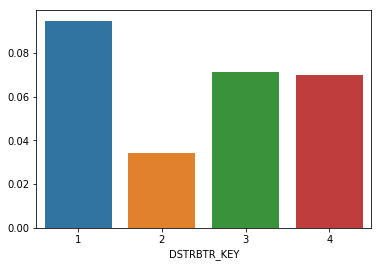

In [361]:
# explore analysis
#1. distributor feature:
a=1-df_train['ontime_ornot'].groupby(df_train['DSTRBTR_KEY']).apply(np.mean)
print(a)
sns.barplot(a.index,a.values)
#conclusion: distributor is a factor

order_month
1.0     0.166667
1.5     0.036304
2.0     0.073801
2.5     0.106897
3.0     0.114667
3.5     0.090909
4.0     0.086957
4.5     0.037415
5.0     0.038462
5.5     0.071611
6.0     0.048980
6.5     0.072727
7.0     0.052632
7.5     0.075975
8.0     0.084592
8.5     0.043590
9.0     0.123393
9.5     0.057751
10.0    0.037572
10.5    0.106017
11.0    0.066265
11.5    0.113483
12.0    0.051667
12.5    0.000000
Name: ontime_ornot, dtype: float64

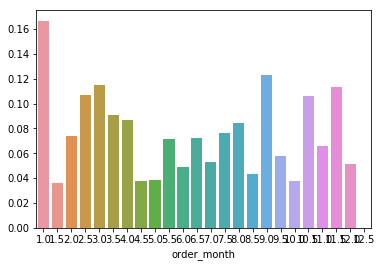

In [362]:
#2. feature engineering: order month
combine=[df_train,df_test]
for data in combine:
    data['order_month']=''
    for j in range(len(data)):
        if data.iloc[j,5].day in range(15):
            a=0
        else:
            a=0.5
        data.iloc[j,51]=data.iloc[j,5].month+a
a=1-df_train['ontime_ornot'].groupby(df_train['order_month']).apply(np.mean)
sns.barplot(a.index,a.values)
a
#conclusion: keep this feature

In [363]:
#3. SHIPPED_PACKAGE_PRICE_AMT : more on tableau
df_train[['SHIPPED_PACKAGE_PRICE_AMT','TOT_AMT']].groupby(df_train['ontime_ornot']).apply(np.mean)




,SHIPPED_PACKAGE_PRICE_AMT,TOT_AMT
ontime_ornot,,
0,36.350598,82.881412
1,30.382483,88.327062


In [365]:
#4. feature engineering use timestamp-----expected delivery time
df_train['expected delivery time']=df_train['EXPECTED_DELIVERY_TS']-df_train['ORDER_TS']
df_test['expected delivery time']=df_test['EXPECTED_DELIVERY_TS']-df_test['ORDER_TS']
print("Expected delivery time for on time")
print(df_train[df_train['ontime_ornot']==1]['expected delivery time'].describe())
print('------------')
print("Expected delivery time for delays")
print(df_train[df_train['ontime_ornot']==0]['expected delivery time'].describe())


Expected delivery time for on time
count                      8086
mean     5 days 17:05:53.476131
std      3 days 16:21:17.901670
min             0 days 21:48:06
25%      2 days 18:49:35.750000
50%             4 days 15:18:21
75%      8 days 01:53:15.250000
max            39 days 21:26:48
Name: expected delivery time, dtype: object
------------
Expected delivery time for delays
count                       686
mean     4 days 08:31:47.288629
std      2 days 18:43:33.584231
min             0 days 22:47:52
25%      2 days 07:12:52.250000
50%             3 days 05:24:30
75%      5 days 05:12:17.750000
max            14 days 19:29:35
Name: expected delivery time, dtype: object


In [366]:
#5. states----on tableau
#rename state column

df_train=df_train.rename(columns={'CITY_STATE_INFO_Vcol':'state'})  
df_test=df_test.rename(columns={'CITY_STATE_INFO_Vcol':'state'}) 


In [367]:
#determined-least
df_train['delivery time range']=df_train['DETERMINED_DELIVERY_TS']-df_train['LEAST_DELIVERY_TS']
df_test['delivery time range']=df_test['DETERMINED_DELIVERY_TS']-df_train['LEAST_DELIVERY_TS']
print("Expected delivery range for on time")
print(df_train[df_train['ontime_ornot']==1]['delivery time range'].describe())
print('------------')
print("Expected delivery range for delay")
print(df_train[df_train['ontime_ornot']==0]['delivery time range'].describe())
#analysis: this is an effective factor, but need to check correlation
#correlation between quantitative attributes
df_train[(df_train['delivery time range'].notnull())&(df_train['TOT_AMT'].notnull())][['delivery time range','expected delivery time','ontime_ornot','SHIPPED_PACKAGE_PRICE_AMT','TOT_AMT']].astype(int).corr().sort_values(by='ontime_ornot',ascending=False)


Expected delivery range for on time
count                      8085
mean     1 days 00:28:19.146567
std      2 days 01:52:10.152815
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:00
max            15 days 00:00:00
Name: delivery time range, dtype: object
------------
Expected delivery range for delay
count                       686
mean     0 days 09:16:16.093294
std      1 days 08:17:55.925594
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:00
max             6 days 00:00:00
Name: delivery time range, dtype: object


,delivery time range,expected delivery time,ontime_ornot,SHIPPED_PACKAGE_PRICE_AMT,TOT_AMT
ontime_ornot,0.082906,0.099334,1.000000,-0.026392,0.012059
expected delivery time,0.726382,1.000000,0.099334,0.084179,-0.001928
delivery time range,1.000000,0.726382,0.082906,-0.015827,-0.001453
TOT_AMT,-0.001453,-0.001928,0.012059,-0.023263,1.000000
SHIPPED_PACKAGE_PRICE_AMT,-0.015827,0.084179,-0.026392,1.000000,-0.023263


Step4: data manipulation after data exploration
    1. one-hot encoding for categorical features
    2. feature scaling for quantitative features
    3. complete null values

In [368]:
#extract factors
df_train_model=df_train[['DSTRBTR_KEY','state','order_month','SHIPPED_PACKAGE_PRICE_AMT','expected delivery time','delivery time range','TOT_AMT','ontime_ornot']]
df_test_model=df_test[['DSTRBTR_KEY','state','order_month','SHIPPED_PACKAGE_PRICE_AMT','expected delivery time','delivery time range','TOT_AMT','ontime_ornot']]

In [369]:
df_train_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8772 entries, 100 to 7050
Data columns (total 8 columns):
DSTRBTR_KEY                  8772 non-null int64
state                        8772 non-null object
order_month                  8772 non-null object
SHIPPED_PACKAGE_PRICE_AMT    8772 non-null float64
expected delivery time       8772 non-null timedelta64[ns]
delivery time range          8771 non-null timedelta64[ns]
TOT_AMT                      8712 non-null float64
ontime_ornot                 8772 non-null int64
dtypes: float64(2), int64(2), object(2), timedelta64[ns](2)
memory usage: 936.8+ KB


In [370]:
#one-hot encoding for distributor, state and month
df_train_model=pd.get_dummies(df_train_model, columns=['DSTRBTR_KEY','order_month','state'])
df_test_model=pd.get_dummies(df_test_model, columns=['DSTRBTR_KEY','order_month','state'])

In [371]:
df_train_model['TOT_AMT']=df_train_model['TOT_AMT'].fillna(df_train_model['TOT_AMT'].median())
df_test_model['TOT_AMT']=df_test_model['TOT_AMT'].fillna(df_test_model['TOT_AMT'].median())

In [372]:
#scalling for SHIPPED_PACKAGE_PRICE_AMT,OT_AMT, and expected delivery time
df_train_model['expected delivery time']=df_train_model['expected delivery time'].astype(int)
df_test_model['expected delivery time']=df_test_model['expected delivery time'].astype(int)
df_train_model['delivery time range']=df_train_model['delivery time range'].astype(int)
df_test_model['delivery time range']=df_test_model['delivery time range'].astype(int)
from sklearn.preprocessing import StandardScaler
df_train_model.iloc[:,0:4]= StandardScaler().fit_transform(df_train_model.iloc[:,0:4])
df_test_model.iloc[:,0:4]= StandardScaler().fit_transform(df_test_model.iloc[:,0:4])


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [373]:
#remove states with too few observations
a=pd.Series(df_train.index).groupby(df_train['state']).agg('count')
print(a[a<10])
df_train_model=df_train_model.drop(['state_AE','state_AK','state_HI','state_PR','state_VI','state_WY'],axis=1)
df_test_model=df_test_model.drop(['state_AK','state_HI','state_VI','state_WY'],axis=1)
#add IA so that train and test data can be same
df_test_model['state_IA']=0
df_test_model['state_DC']=0
df_test_model=df_test_model[list(df_train_model.columns)]




state
AE    9
AK    3
HI    4
PR    1
VI    9
WY    6
dtype: int64


In [374]:
df_train_model.to_csv('df_train_model.csv')
df_test_model.to_csv('df_test_model.csv')

In [4]:
df_train_model=pd.read_csv('df_train_model.csv')
df_test_model=pd.read_csv('df_test_model.csv')

Step5: model data

In [5]:
#split into X and y
X=df_train_model.drop('ontime_ornot',axis=1)
y=df_train_model['ontime_ornot']

In [29]:
#import model
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process
from sklearn.neural_network import MLPClassifier
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(random_state=42),
    ensemble.GradientBoostingClassifier(random_state=42),
    ensemble.RandomForestClassifier(random_state=42),
    ensemble.BaggingClassifier(random_state=42),
    linear_model.LogisticRegressionCV(),
    neighbors.KNeighborsClassifier(),
    svm.LinearSVC(),
    naive_bayes.BernoulliNB(), 
]
    
model_name=['AdaBoostClassifier',
    'GradientBoostingClassifier',
    'RandomForestClassifier',
    'BaggingClassifier',
    'linear_model.LogisticRegressionCV()',
    'neighbors.KNeighborsClassifier',
    'svm.LinearSVC()',
    'naive_bayes.BernoulliNB()',
]    
    

In [9]:
#model evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


Performance=[]
for model in MLA:
    Accuracy=[]
    Recall=[]

    model.fit(X,y)
    y_predict=model.predict(X)

    train_accuracy=1-sum((y-y_predict).abs())/len(y)
    train_recall=sum((y==0) & (y_predict==0))/sum((y==0))
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(X.values):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model.fit(X_train,y_train)
        y_predict=model.predict(X_test)
        recall=sum((y_test==0) & (y_predict==0))/sum((y_test==0))
        accuracy=accuracy_score(y_test,y_predict)
        Accuracy.append(accuracy)
        recall=sum((y_test==0) & (y_predict==0))/sum((y_test==0))
        Recall.append(recall)
    Accuracy=np.mean(np.array([Accuracy]))
    Recall=np.mean(np.array([Recall]))   
    performance=[train_accuracy,train_recall,Accuracy,Recall]
    Performance.append(performance)

    

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Con

In [12]:
df_Performance=pd.DataFrame(Performance)
df_Performance.columns=['train accuracy','train recall','validation accuracy','Validation recall']
df_Performance.index=model_name
df_Performance.sort_values(by='validation accuracy',ascending=False)


#analysis:
#considering accuracy and recall, Bagging decision trees and Random Forest are the best model


,train accuracy,train recall,validation accuracy,Validation recall
RandomForestClassifier,0.996124,0.957726,0.938554,0.373761
BaggingClassifier,0.996124,0.956268,0.932741,0.387722
GradientBoostingClassifier,0.931031,0.118076,0.926015,0.086256
AdaBoostClassifier,0.923165,0.020408,0.922481,0.021514
naive_bayes.BernoulliNB(),0.922595,0.018950,0.922253,0.017869
linear_model.LogisticRegressionCV(),0.921797,0.000000,0.921797,0.000000
neighbors.KNeighborsClassifier,0.937642,0.309038,0.918491,0.136849
svm.LinearSVC(),0.883949,0.084548,0.918149,0.004330


In [24]:
#use stratified k fold for skewed dataset
#tune bagging decision tree and random forest parameters and threshold based on metrics



from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score
Performance=[]

#bagging
for thr in (0.2,0.4):
    for i in np.arange(20,200,10):
        for j in (0.5,0.8,1.0):
            pr=[]
            re=[]
            ac=[]
            model=ensemble.BaggingClassifier(random_state=42,n_estimators=i,max_samples=j,n_jobs=-1)
            kf = StratifiedKFold(n_splits=5, random_state=42)
            for train_index, test_index in kf.split(X.values,y.values):
                X_train_folds = X.values[train_index]
                y_train_folds = (y.values[train_index])
                X_test_fold = X.values[test_index]
                y_test_fold = (y.values[test_index])
                model.fit(X_train_folds, y_train_folds)
                y_predict=pd.DataFrame(model.predict_proba(X_test_fold))
                b=y_predict.iloc[:,0]
                y_predict['prediction']=np.where(b>=thr,0,1)
                y_predict=y_predict['prediction'].values
                m=confusion_matrix(y_test_fold,y_predict)
                re.append(m[0,0]/(m[0,0]+m[0,1]))
                pr.append(m[0,0]/(m[0,0]+m[1,0]))
                ac.append((m[0,0]+m[1,1])/(m[0,0]+m[1,1]+m[0,1]+m[1,0]))
            AC=sum(ac)/len(ac)
            PR=sum(pr)/len(pr)
            RE=sum(re)/len(re)
            performance=['Bagging Decision Tree',thr,i,j,AC,RE,PR,PR/4+RE*3/4]
            Performance.append(performance)
#random forest
for thr in (0.2,0.4):
    for i in np.arange(20,200,10):
        for j in (1,3,5):
            pr=[]
            re=[]
            ac=[]
            model=ensemble.RandomForestClassifier(random_state=42,n_estimators=i,min_samples_leaf=j,n_jobs=-1)
            kf = StratifiedKFold(n_splits=5, random_state=42)
            for train_index, test_index in kf.split(X.values,y.values):
                X_train_folds = X.values[train_index]
                y_train_folds = (y.values[train_index])
                X_test_fold = X.values[test_index]
                y_test_fold = (y.values[test_index])
                model.fit(X_train_folds, y_train_folds)
                y_predict=pd.DataFrame(model.predict_proba(X_test_fold))
                b=y_predict.iloc[:,0]
                y_predict['prediction']=np.where(b>=thr,0,1)
                y_predict=y_predict['prediction'].values
                m=confusion_matrix(y_test_fold,y_predict)
                re.append(m[0,0]/(m[0,0]+m[0,1]))
                pr.append(m[0,0]/(m[0,0]+m[1,0]))
                ac.append((m[0,0]+m[1,1])/(m[0,0]+m[1,1]+m[0,1]+m[1,0]))
            AC=sum(ac)/len(ac)
            PR=sum(pr)/len(pr)
            RE=sum(re)/len(re)
            performance=['Random Forest',thr,i,j,AC,RE,PR,PR/4+RE*3/4]
            Performance.append(performance)


        
df_Performance=pd.DataFrame(Performance)
df_Performance.columns=['model type','Threshold','n_estimator','max_samples/min_samples_leaf','validation accuracy','validation recall','validation precision','1/4 pr+3/4recall']


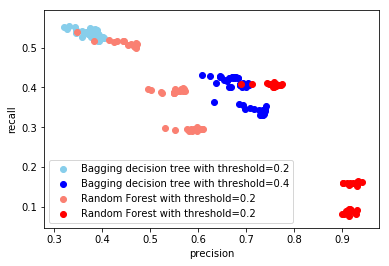

In [25]:
#visualize the recall-precision within different thresholds and model types
df_Performance=df_Performance.sort_values(by='validation precision',ascending=False)

plt.scatter('validation precision','validation recall', data=df_Performance[(df_Performance['model type']=='Bagging Decision Tree')&(df_Performance['Threshold']==0.2)],color='skyblue',label='Bagging decision tree with threshold=0.2')
plt.scatter('validation precision','validation recall', data=df_Performance[(df_Performance['model type']=='Bagging Decision Tree')&(df_Performance['Threshold']==0.4)],color='blue',label='Bagging decision tree with threshold=0.4')
plt.scatter('validation precision','validation recall', data=df_Performance[(df_Performance['model type']=='Random Forest')&(df_Performance['Threshold']==0.2)],color='salmon',label='Random Forest with threshold=0.2')
plt.scatter('validation precision','validation recall', data=df_Performance[(df_Performance['model type']=='Random Forest')&(df_Performance['Threshold']==0.4)],color='red',label='Random Forest with threshold=0.2')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend()


In [36]:
# If the compensation costs for delays are relatively very high
df_Performance.sort_values(by='1/4 pr+3/4recall',ascending=False).head(n=10)

#conclusion:
#High compensation costs decision:the best model is bagging decision tree,n_estimator=70, max samples=1.0,threeshold=0.2




,model type,Threshold,n_estimator,max_samples/min_samples_leaf,validation accuracy,validation recall,validation precision,1/4 pr+3/4recall,1/3pr+2/3recall
17,Bagging Decision Tree,0.2,70,1.0,0.896718,0.546673,0.386374,0.506598,0.493240
11,Bagging Decision Tree,0.2,50,1.0,0.893184,0.549582,0.375099,0.505961,0.491421
20,Bagging Decision Tree,0.2,80,1.0,0.897972,0.543764,0.390294,0.505396,0.492607
14,Bagging Decision Tree,0.2,60,1.0,0.894210,0.546662,0.377802,0.504447,0.490376
138,Random Forest,0.2,120,1.0,0.916895,0.511658,0.471578,0.501638,0.498298
144,Random Forest,0.2,140,1.0,0.917351,0.510187,0.473812,0.501094,0.498062
5,Bagging Decision Tree,0.2,30,1.0,0.882242,0.552512,0.343441,0.500245,0.482822
213,Random Forest,0.4,190,1.0,0.944596,0.408135,0.774672,0.499769,0.530314
126,Random Forest,0.2,80,1.0,0.911993,0.517497,0.446482,0.499743,0.493826
2,Bagging Decision Tree,0.2,20,1.0,0.877454,0.555422,0.331727,0.499498,0.480857


In [27]:
# If the compensation costs for delays are not relatively high
df_Performance['1/3pr+2/3recall']=2/3*df_Performance['validation recall']+1/3*df_Performance['validation precision']
df_Performance.sort_values(by='1/3pr+2/3recall',ascending=False).head(n=10)
#conclusion:
#High action costs decision:the best model is random forest,n_estimator=190, min leaf=1,threeshold=0.4

,model type,Threshold,n_estimator,max_samples/min_samples_leaf,validation accuracy,validation recall,validation precision,1/4 pr+3/4recall,1/3pr+2/3recall
213,Random Forest,0.4,190,1.0,0.944596,0.408135,0.774672,0.499769,0.530314
210,Random Forest,0.4,180,1.0,0.944368,0.406675,0.772224,0.498062,0.528525
174,Random Forest,0.4,60,1.0,0.943912,0.412515,0.757987,0.498883,0.527672
207,Random Forest,0.4,170,1.0,0.944140,0.406675,0.768060,0.497021,0.527137
201,Random Forest,0.4,150,1.0,0.943912,0.408124,0.762302,0.496669,0.526184
204,Random Forest,0.4,160,1.0,0.944026,0.405215,0.767660,0.495827,0.526030
171,Random Forest,0.4,50,1.0,0.943684,0.409595,0.757254,0.496510,0.525481
198,Random Forest,0.4,140,1.0,0.943684,0.408135,0.757977,0.495595,0.524749
195,Random Forest,0.4,130,1.0,0.943570,0.406686,0.758070,0.494532,0.523814
186,Random Forest,0.4,100,1.0,0.943570,0.406686,0.757830,0.494472,0.523734


In [32]:
#test on test data now
model=ensemble.BaggingClassifier(random_state=42,n_estimators=70)
X_test=df_test_model.drop('ontime_ornot',axis=1)
y_test=df_test_model['ontime_ornot']
model.fit(X,y)
y_predict=pd.DataFrame(model.predict_proba(X_test))
b=y_predict.iloc[:,0]
y_predict['prediction']=np.where(b>=0.2,0,1)
m=confusion_matrix(y_test,y_predict['prediction'])
re=m[0,0]/(m[0,0]+m[0,1])
pr=m[0,0]/(m[0,0]+m[1,0])
ac=(m[0,0]+m[1,1])/(m[0,0]+m[1,1]+m[0,1]+m[1,0])

print('test result: accuracy','{:.3%}'.format(ac),'recall','{:.3%}'.format(re),'precision','{:.3%}'.format(pr))
print('If compensation costs for delay is relatively high, the model we use will capture 49.7% delays in 21.6% orders')

model=ensemble.RandomForestClassifier(random_state=42,n_estimators=190)
X_test=df_test_model.drop('ontime_ornot',axis=1)
y_test=df_test_model['ontime_ornot']
model.fit(X,y)
y_predict=pd.DataFrame(model.predict_proba(X_test))
b=y_predict.iloc[:,0]
y_predict['prediction']=np.where(b>=0.4,0,1)
m=confusion_matrix(y_test,y_predict['prediction'])
re=m[0,0]/(m[0,0]+m[0,1])
pr=m[0,0]/(m[0,0]+m[1,0])
ac=(m[0,0]+m[1,1])/(m[0,0]+m[1,1]+m[0,1]+m[1,0])

print('test result: accuracy','{:.3%}'.format(ac),'recall','{:.3%}'.format(re),'precision','{:.3%}'.format(pr))
print('If the compensation costs for delay is not very high compared to costs to avoid delay, the model we use will capture 26.9% delays in 11% orders')




test result: accuracy 89.193% recall 49.708% precision 36.017%
If compensation costs for delay is relatively high, the model we use will capture 49.7% delays in 21.6% orders
test result: accuracy 93.434% recall 26.901% precision 70.769%
If the compensation costs for delay is not very high compared to costs to avoid delay, the model we use will capture 26.9% delays in 11% orders
